In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt

In [2]:
gc.collect()

0

### data 1: concat_df

In [3]:
dtypes = {  
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'day'           : 'uint8',
            'hour'          : 'uint8',
            'minute'        : 'uint8',
            'ip_count'      : 'uint32',
            'ip_day_hour_minute_count' : 'uint32',
            'os_device_count'          : 'uint32',
            'os_app_channel_count'     : 'uint32',
            #'ip_day_hour_count'        : 'uint32',
            #'ip_app_count'             : 'uint32',
            #'ip_app_os_count'          : 'uint32',
            'ip_device_count'          : 'uint32',
            'app_channel_count'        : 'uint32',
            'next_click'               : 'int64',
            'prev_click'               : 'int64'        
            }

to_read = ['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'minute',
            'ip_count', 'ip_day_hour_minute_count',
            'os_device_count',
            'os_app_channel_count',
            #'ip_day_hour_count',
            #'ip_app_count',
            #'ip_app_os_count',
            'ip_device_count',
            'app_channel_count',
            'next_click',
            'prev_click'
          ]

In [4]:
concat_df_tmp = pd.read_csv('tmp/concat_df.csv.gz', compression='gzip', dtype=dtypes, usecols=to_read, chunksize = 10**6)
concat_df = pd.concat(concat_df_tmp)

In [5]:
del concat_df_tmp
gc.collect()

406

### data 2: time feature

In [6]:
time_feature = pd.read_csv('tmp/time_diff.csv.gz', compression='gzip', usecols=['log2_time_diff_first_seen'])

### data 3: agg future

In [7]:
agg_dtype = {
    'nuniq_ip_channel':            'uint32',
    'cumcnt_ip_device_os_app':     'uint32',
    'nuniq_ip_day_hour':           'uint32',
    'nuniq_ip_app':                'uint32',
    'nuniq_ip_app_os':             'uint32',
    'nuniq_ip_device':             'uint32',
    'nuniq_app_channel':           'uint32',
    'cumcnt_ip_os':                'uint32',
    'nuniq_ip_device_os_app':      'uint32',
    'ip_tcount':                   'uint32',
    'ip_app_count':                'uint32',
    'ip_app_os_count':             'uint32',
    'ip_tchan_count':              'float32',
    'ip_app_os_var':               'float32',
    'ip_app_channel_var_day':      'float32',
    'ip_app_channel_mean_hour':    'float32'
}

agg_to_read = ['nuniq_ip_channel', 
               'cumcnt_ip_device_os_app',
               'nuniq_ip_day_hour',
               'nuniq_ip_app',
               'nuniq_ip_app_os',
               'nuniq_ip_device',
               'nuniq_app_channel',
               'cumcnt_ip_os',
               'nuniq_ip_device_os_app',
               'ip_tcount',
               'ip_app_count',
               'ip_app_os_count',
               'ip_tchan_count',
               'ip_app_os_var',
               'ip_app_channel_var_day',
               'ip_app_channel_mean_hour']

In [8]:
agg_feature_tmp = pd.read_csv('tmp/agg_features.csv.gz', compression='gzip', dtype=agg_dtype, 
                              usecols=agg_to_read, chunksize=10**6)

agg_feature = pd.concat(agg_feature_tmp)

In [9]:
del agg_feature_tmp
gc.collect()

406

In [10]:
fill_agg = ['ip_tchan_count','ip_app_os_var','ip_app_channel_var_day','ip_app_channel_mean_hour']
agg_feature[fill_agg] = agg_feature[fill_agg].fillna(agg_feature[fill_agg].mean())

### data 4: isolation forest score

In [11]:
if_score = pd.read_csv('tmp/if_score_v2.csv.gz', compression='gzip', dtype={'if_score':'float16'})

In [12]:
gc.collect()

7

### concat all

In [17]:
concat_df = pd.concat([concat_df, time_feature, agg_feature, if_score], axis=1)

In [18]:
del time_feature, agg_feature, if_score
gc.collect()

123

In [19]:
train_y = pd.read_csv('tmp/train_y.csv.gz', compression='gzip')

In [20]:
y = train_y['is_attributed'].values

In [21]:
def log_bin_feature(df, features):
    for fea in features: 
        df[fea]= np.log2(1 + df[fea].values).astype(int)

In [22]:
features = ['ip_count',
            'ip_day_hour_minute_count',
            'os_device_count',
            'os_app_channel_count',
            'ip_tcount',
            'ip_app_count',
            'ip_app_os_count',
            'ip_device_count',
            'app_channel_count',
            'nuniq_ip_channel',
            'cumcnt_ip_device_os_app',
            'nuniq_ip_day_hour',
            'nuniq_ip_app',
            'nuniq_ip_app_os',
            'nuniq_ip_device',
            'nuniq_app_channel',
            'cumcnt_ip_os',
            'nuniq_ip_device_os_app',
            'next_click',
            'prev_click']

log_bin_feature(concat_df, features)

In [23]:
gc.collect()

142

### Define Model

In [24]:
num_train = 40000000
num_val = 2000000
target = "is_attributed"
categorical_features = ['app','os','channel','device', 'hour', 'day', 'minute']
predictors = list(concat_df.columns) 

not_use = ['ip']
for x in not_use: predictors.remove(x)

In [25]:
lgbtrain = lgb.Dataset(concat_df.iloc[:(num_train-num_val)][predictors].values, label= y[:(num_train-num_val)],
                       feature_name = predictors,
                       categorical_feature = categorical_features,
                       free_raw_data=True
                      )

In [26]:
gc.collect()

27

In [27]:
lgbval = lgb.Dataset(concat_df.iloc[(num_train-num_val):num_train][predictors].values, label= y[(num_train-num_val):],
                     feature_name = predictors,
                     categorical_feature = categorical_features,
                     reference = lgbtrain,
                     free_raw_data = True
                     )

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 4,
    'verbose': 0,
    'metric':'auc',     
 
    'learning_rate': 0.08,
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    #'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight': 200
}

In [28]:
lgb_params = {
    'metric':'auc', 
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'nthread': 4,
        
    'learning_rate': 0.08,  #was .010
    #'is_unbalance': 'true',  # replaced with scale_pos_weight argument
    'num_leaves': 7,          # 2^max_depth - 1
    'max_depth': 4,           # -1 means no limit
    'min_child_samples': 100, # Minimum number of data need in a child(min_data_in_leaf)
    #'max_bin': 100,          # Number of bucketed bin for feature values
    'subsample': 0.7,         # Subsample ratio of the training instance.
    'subsample_freq': 1,      # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,    # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight': 200   # because training data is extremely unbalanced
}

In [29]:
evals_results = {}
num_boost_round = 1000
early_stopping_rounds = 30

booster = lgb.train(
     lgb_params, 
     lgbtrain, 
     valid_sets=[lgbtrain, lgbval], 
     valid_names=['train','validation'], 
     evals_result=evals_results, 
     num_boost_round=num_boost_round,
     early_stopping_rounds=early_stopping_rounds,
     verbose_eval=1
    )

/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	train's auc: 0.947499	validation's auc: 0.974344
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.950886	validation's auc: 0.975588
[3]	train's auc: 0.951074	validation's auc: 0.975449
[4]	train's auc: 0.952089	validation's auc: 0.976393
[5]	train's auc: 0.952923	validation's auc: 0.976488
[6]	train's auc: 0.961901	validation's auc: 0.976042
[7]	train's auc: 0.961842	validation's auc: 0.976052
[8]	train's auc: 0.963519	validation's auc: 0.977492
[9]	train's auc: 0.964787	validation's auc: 0.978202
[10]	train's auc: 0.965241	validation's auc: 0.978359
[11]	train's auc: 0.967191	validation's auc: 0.978641
[12]	train's auc: 0.967458	validation's auc: 0.978704
[13]	train's auc: 0.968682	validation's auc: 0.978316
[14]	train's auc: 0.968772	validation's auc: 0.979179
[15]	train's auc: 0.969271	validation's auc: 0.980412
[16]	train's auc: 0.969335	validation's auc: 0.980838
[17]	train's auc: 0.969669	validation's auc: 0.98106
[18]	train's auc: 0.96964	vali

[152]	train's auc: 0.981955	validation's auc: 0.990031
[153]	train's auc: 0.981967	validation's auc: 0.990045
[154]	train's auc: 0.981983	validation's auc: 0.990062
[155]	train's auc: 0.982001	validation's auc: 0.990068
[156]	train's auc: 0.982019	validation's auc: 0.990138
[157]	train's auc: 0.982039	validation's auc: 0.990139
[158]	train's auc: 0.982058	validation's auc: 0.990134
[159]	train's auc: 0.982068	validation's auc: 0.990141
[160]	train's auc: 0.982085	validation's auc: 0.990153
[161]	train's auc: 0.98211	validation's auc: 0.990163
[162]	train's auc: 0.982122	validation's auc: 0.990173
[163]	train's auc: 0.982144	validation's auc: 0.990155
[164]	train's auc: 0.982155	validation's auc: 0.990172
[165]	train's auc: 0.98217	validation's auc: 0.990144
[166]	train's auc: 0.982178	validation's auc: 0.990125
[167]	train's auc: 0.982197	validation's auc: 0.990146
[168]	train's auc: 0.982207	validation's auc: 0.990149
[169]	train's auc: 0.982221	validation's auc: 0.990152
[170]	train'

In [30]:
ax = lgb.plot_importance(booster, max_num_features=25)

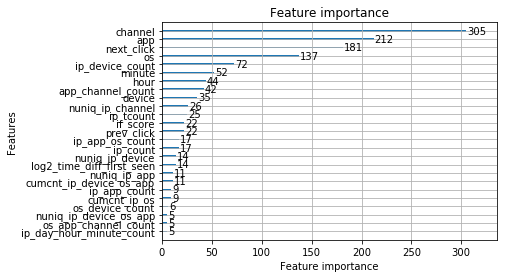

In [31]:
plt.show()

Prediction

In [32]:
preditions=booster.predict(concat_df.iloc[num_train:][predictors].values)

preditions_2=booster.predict(concat_df.iloc[num_train:][predictors].values)

preditions_3 = 0.3 * preditions_2 + 0.7 * preditions

Submission

In [34]:
sub = pd.read_csv('data/sample_submission.csv.zip')

In [35]:
sub['is_attributed'] = preditions

In [36]:
sub.to_csv('output/lgb_sub14_new_feature.csv', float_format='%.8f', index=False)